# Data Integration

## Load Data

In [543]:
import pandas as pd
import numpy as np
import matplotlib

pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 300)

covidCounty = pd.read_csv('./COVID_county_data.csv')
acs2017 = pd.read_csv('./acs2017_census_tract_data.csv')
acs2017.head(5)

,TractId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,VotingAgeCitizen,Income,IncomeErr,IncomePerCap,IncomePerCapErr,Poverty,ChildPoverty,Professional,Service,Office,Construction,Production,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001020100,Alabama,Autauga County,1845,899,946,2.4,86.3,5.2,0.0,1.2,0.0,1407,67826.0,14560.0,33018.0,6294.0,10.7,20.8,38.5,15.6,22.8,10.8,12.4,94.2,3.3,0.0,0.5,0.0,2.1,24.5,881,74.2,21.2,4.5,0.0,4.6
1,1001020200,Alabama,Autauga County,2172,1167,1005,1.1,41.6,54.5,0.0,1.0,0.0,1652,41287.0,3819.0,18996.0,2453.0,22.4,35.8,30.5,24.9,22.9,6.3,15.4,90.5,9.1,0.0,0.0,0.5,0.0,22.2,852,75.9,15.0,9.0,0.0,3.4
2,1001020300,Alabama,Autauga County,3385,1533,1852,8.0,61.4,26.5,0.6,0.7,0.4,2480,46806.0,9496.0,21236.0,2562.0,14.7,21.1,27.9,19.4,33.3,9.9,9.6,88.3,8.4,0.0,1.0,0.8,1.5,23.1,1482,73.3,21.1,4.8,0.7,4.7
3,1001020400,Alabama,Autauga County,4267,2001,2266,9.6,80.3,7.1,0.5,0.2,0.0,3257,55895.0,4369.0,28068.0,3190.0,2.3,1.7,29.0,16.6,25.8,9.1,19.5,82.3,11.2,0.0,1.5,2.9,2.1,25.9,1849,75.8,19.7,4.5,0.0,6.1
4,1001020500,Alabama,Autauga County,9965,5054,4911,0.9,77.5,16.4,0.0,3.1,0.0,7229,68143.0,14424.0,36905.0,10706.0,12.2,17.9,48.8,13.8,20.5,3.5,13.4,86.9,11.2,0.0,0.8,0.3,0.7,21.0,4787,71.4,24.1,4.5,0.0,2.3


## A. Aggregate Census Data to County Level

In [544]:
acs2017County = acs2017['County']
print(f"There is {len(acs2017County.unique())} county name \
in whole {acs2017County.size} lines.")

There is 1955 county name in whole 74001 lines.


In [545]:
def aggCensusData(group):
    """This function calculate the total population, poverty, and percapitaincome.

    Population: Sum, add all records belong to one county.
    Poverty: First, compute the number of poverty people in every record.
        Second, add them together and divide total population to reduce error.
    PerCapitaIncome: Similar method with poverty.
    """
    newS = {'Population': group['TotalPop'].sum()}
    newS['Poverty'] = np.sum(group['Poverty'] * group['TotalPop'] /100) / newS['Population'] * 100
    newS['PerCapitaIncome'] = np.sum(group['IncomePerCap'] * group['TotalPop']) / newS['Population']
    return newS


acsAgged = acs2017.groupby(['County', 'State']).apply(aggCensusData).reset_index()
acsAgged[['Population', 'Poverty', 'PerCapitaIncome']] = pd.DataFrame(acsAgged[0].tolist())
acsAgged = acsAgged.drop(columns=0)

In [546]:
acsAgged.iloc[[1759, 3046, 1234, 1822]]

,County,State,Population,Poverty,PerCapitaIncome
1759,Loudoun County,Virginia,374558,3.689598,50455.645745
3046,Washington County,Oregon,572071,10.321202,35369.047499
1234,Harlan County,Kentucky,27548,35.669482,15456.971032
1822,Malheur County,Oregon,30421,24.298225,17567.504323


## B. Simplify the COVID Data

In [547]:
covidCounty.head(5)

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0.0
1,2020-01-22,Snohomish,Washington,53061.0,1,0.0
2,2020-01-23,Snohomish,Washington,53061.0,1,0.0
3,2020-01-24,Cook,Illinois,17031.0,1,0.0
4,2020-01-24,Snohomish,Washington,53061.0,1,0.0


In [548]:
dec20 = covidCounty.loc[covidCounty['date'] == '2020-12-31']
total = covidCounty.loc[covidCounty['date'] == '2021-02-20']
total = total.drop(columns=['date', 'fips'])
dec20 = dec20.drop(columns=['date', 'fips'])

covidCountyAgged = total.merge(dec20, how='left', on=['county', 'state'], suffixes=('Total', 'Dec2020'))
covidCountyAgged.head(5)

,county,state,casesTotal,deathsTotal,casesDec2020,deathsDec2020
0,Autauga,Alabama,6092,85.0,4190.0,48.0
1,Baldwin,Alabama,19392,262.0,13601.0,161.0
2,Barbour,Alabama,2067,50.0,1514.0,32.0
3,Bibb,Alabama,2414,58.0,1834.0,46.0
4,Blount,Alabama,6040,125.0,4641.0,63.0


In [549]:
outputCounty = [('Virginia', 'Loudoun'),
                ('Oregon', 'Washington'),
                ('Kentucky', 'Harlan'),
                ('Oregon', 'Malheur'),]

def printCounty(data, hasCounty=False):
    for s, c in outputCounty:
        if hasCounty:
            c += ' County'
        print(data.loc[(covidCountyAgged['state'] == s) & (covidCountyAgged['county'] == c)])

covidCountyAgged.iloc[[2995, 2260, 1048, 2249]]

,county,state,casesTotal,deathsTotal,casesDec2020,deathsDec2020
2995,Loudoun,Virginia,22557,199.0,14169.0,159.0
2260,Washington,Oregon,20866,209.0,16070.0,142.0
1048,Harlan,Kentucky,2352,68.0,1538.0,18.0
2249,Malheur,Oregon,3331,58.0,2914.0,50.0


## C. Integrate COVID Data with ACS Data

In [550]:
covidCountyAgged = covidCountyAgged.rename(columns={
    'county': 'County',
    'state': 'State',
    'casesDec2020': 'Dec2020Cases',
    'deathsDec2020': 'Dec2020Deaths',
    'casesTotal': 'TotalCases',
    'deathsTotal': 'TotalDeaths',
})
acsAgged['County'] = acsAgged['County'].map(lambda x: x.split()[0])

df = acsAgged.merge(covidCountyAgged, how='left', on=['County', 'State'])
df.head(5)

,County,State,Population,Poverty,PerCapitaIncome,TotalCases,TotalDeaths,Dec2020Cases,Dec2020Deaths
0,Abbeville,South Carolina,24788,22.663628,19234.247176,2174.0,34.0,1275.0,25.0
1,Acadia,Louisiana,62607,21.630767,21590.908876,5999.0,181.0,5082.0,153.0
2,Accomack,Virginia,32840,19.905271,24265.653959,2552.0,35.0,1698.0,27.0
3,Ada,Idaho,435117,11.909603,31642.314649,46190.0,428.0,38417.0,355.0
4,Adair,Iowa,7192,9.479060,28860.857620,790.0,26.0,606.0,17.0


In [551]:
df.loc[df['State'] == 'Oregon']

,County,State,Population,Poverty,PerCapitaIncome,TotalCases,TotalDeaths,Dec2020Cases,Dec2020Deaths
126,Baker,Oregon,15980,15.083855,25820.273154,629.0,7.0,472.0,5.0
197,Benton,Oregon,88249,22.421152,30872.824361,2248.0,16.0,1347.0,11.0
533,Clackamas,Oregon,399962,8.976120,37550.849108,13196.0,172.0,10058.0,114.0
558,Clatsop,Oregon,38021,12.190090,28114.625523,766.0,6.0,553.0,3.0
631,Columbia,Oregon,50207,12.315329,28459.688051,1208.0,21.0,837.0,14.0
656,Coos,Oregon,62921,17.896488,26007.212997,1347.0,18.0,756.0,9.0
697,Crook,Oregon,21717,15.320864,24238.814477,765.0,18.0,448.0,7.0
718,Curry,Oregon,22377,15.408656,26925.536399,394.0,6.0,278.0,3.0
796,Deschutes,Oregon,175321,12.100898,31574.934092,5839.0,58.0,3976.0,22.0
839,Douglas,Oregon,107576,17.025995,25001.732924,2312.0,51.0,1387.0,39.0


## D. Analysis

In [552]:
# normalized COVID related data:
df['normalizedTotalCases'] = df.apply(lambda x: x['TotalCases'] * 100000 / x['Population'], axis=1)
df['normalizedDec2020Cases'] = df.apply(lambda x: x['Dec2020Cases'] * 100000 / x['Population'], axis=1)
df['normalizedTotalDeaths'] = df.apply(lambda x: x['TotalDeaths'] * 100000 / x['Population'], axis=1)
df['normalizedDec2020Deaths'] = df.apply(lambda x: x['Dec2020Deaths'] * 100000 / x['Population'], axis=1)

dfOregon = df.loc[df['State'] == 'Oregon']

0.3340728988157821


<AxesSubplot:xlabel='normalizedTotalCases', ylabel='Poverty'>

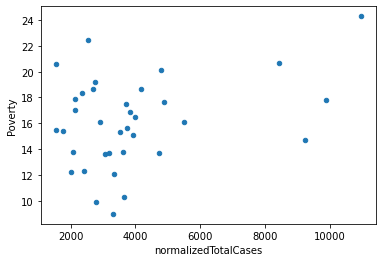

In [563]:
# COVID total cases vs. % population in poverty
print(dfOregon['normalizedTotalCases'].corr(dfOregon['Poverty']))
dfOregon.plot.scatter(x='normalizedTotalCases', y='Poverty')

0.44641856196714574


<AxesSubplot:xlabel='normalizedTotalDeaths', ylabel='Poverty'>

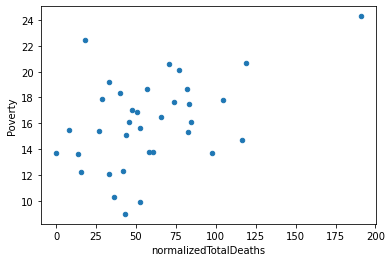

In [565]:
# COVID total deaths vs. % population in poverty
print(dfOregon['normalizedTotalDeaths'].corr(dfOregon['Poverty']))
dfOregon.plot.scatter(x='normalizedTotalDeaths', y='Poverty')

-0.4230772423331276


<AxesSubplot:xlabel='normalizedTotalCases', ylabel='PerCapitaIncome'>

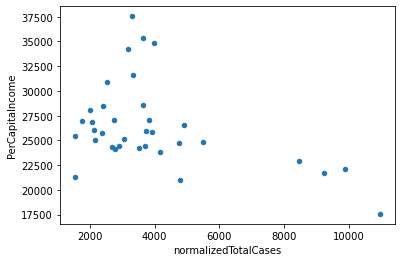

In [566]:
# COVID total cases vs. Per Capita Income level
print(dfOregon['normalizedTotalCases'].corr(dfOregon['PerCapitaIncome']))
dfOregon.plot.scatter(x='normalizedTotalCases', y='PerCapitaIncome')

-0.6038943461719376


<AxesSubplot:xlabel='normalizedTotalDeaths', ylabel='PerCapitaIncome'>

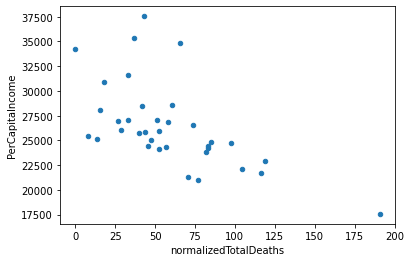

In [567]:
# COVID total cases vs. Per Capita Income level
print(dfOregon['normalizedTotalDeaths'].corr(dfOregon['PerCapitaIncome']))
dfOregon.plot.scatter(x='normalizedTotalDeaths', y='PerCapitaIncome')

0.31337666047094387


<AxesSubplot:xlabel='normalizedDec2020Cases', ylabel='Poverty'>

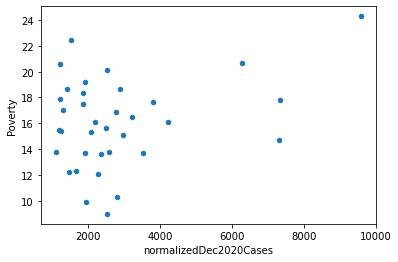

In [568]:
# COVID cases during December 2020 vs. % population in poverty
print(dfOregon['normalizedDec2020Cases'].corr(dfOregon['Poverty']))
dfOregon.plot.scatter(x='normalizedDec2020Cases', y='Poverty')

0.4185024590219378


<AxesSubplot:xlabel='normalizedDec2020Deaths', ylabel='Poverty'>

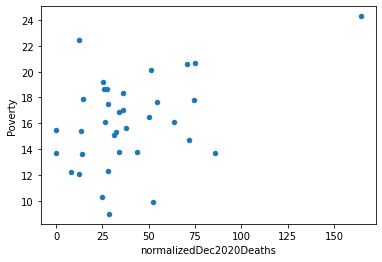

In [569]:
# COVID deaths during December 2020 vs. % population in poverty
print(dfOregon['normalizedDec2020Deaths'].corr(dfOregon['Poverty']))
dfOregon.plot.scatter(x='normalizedDec2020Deaths', y='Poverty')

-0.3990775130803367


<AxesSubplot:xlabel='normalizedDec2020Cases', ylabel='PerCapitaIncome'>

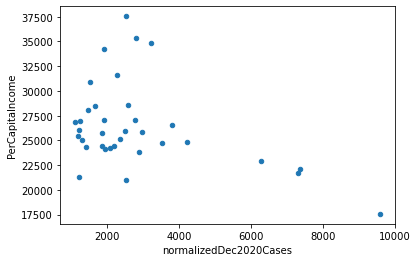

In [570]:
# COVID cases during December 2020 vs. Per Capita Income level
print(dfOregon['normalizedDec2020Cases'].corr(dfOregon['PerCapitaIncome']))
dfOregon.plot.scatter(x='normalizedDec2020Cases', y='PerCapitaIncome')

-0.5610193309143583


<AxesSubplot:xlabel='normalizedDec2020Deaths', ylabel='PerCapitaIncome'>

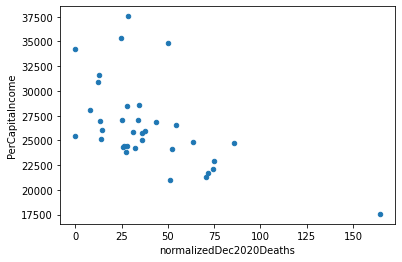

In [571]:
# COVID deaths during December 2020 vs. Per Capita Income level
print(dfOregon['normalizedDec2020Deaths'].corr(dfOregon['PerCapitaIncome']))
dfOregon.plot.scatter(x='normalizedDec2020Deaths', y='PerCapitaIncome')

-0.03625034757555473


<AxesSubplot:xlabel='normalizedTotalCases', ylabel='Poverty'>

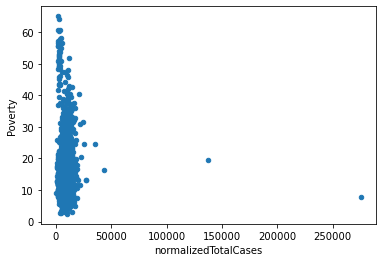

In [554]:
# a
print(df['normalizedTotalCases'].corr(df['Poverty']))
df.plot.scatter(x='normalizedTotalCases', y='Poverty')

0.168169895401471


<AxesSubplot:xlabel='normalizedTotalDeaths', ylabel='Poverty'>

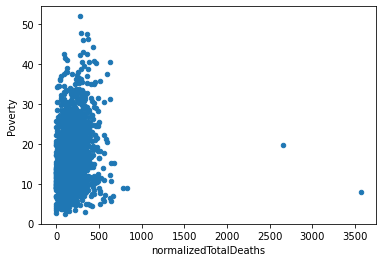

In [555]:
# b
print(df['normalizedTotalDeaths'].corr(df['Poverty']))
df.plot.scatter(x='normalizedTotalDeaths', y='Poverty')

-0.0008635265119192699


<AxesSubplot:xlabel='normalizedTotalCases', ylabel='PerCapitaIncome'>

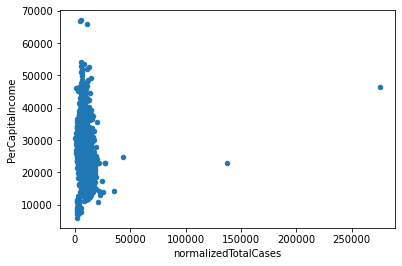

In [556]:
# c
print(df['normalizedTotalCases'].corr(df['PerCapitaIncome']))
df.plot.scatter(x='normalizedTotalCases', y='PerCapitaIncome')

-0.16322573192413595


<AxesSubplot:xlabel='normalizedTotalDeaths', ylabel='PerCapitaIncome'>

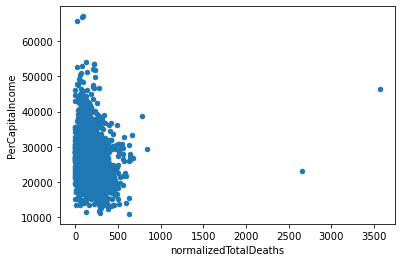

In [557]:
# d
print(df['normalizedTotalDeaths'].corr(df['PerCapitaIncome']))
df.plot.scatter(x='normalizedTotalDeaths', y='PerCapitaIncome')

-0.04691750985723975


<AxesSubplot:xlabel='normalizedDec2020Cases', ylabel='Poverty'>

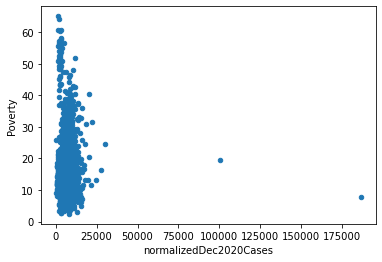

In [558]:
# e
print(df['normalizedDec2020Cases'].corr(df['Poverty']))
df.plot.scatter(x='normalizedDec2020Cases', y='Poverty')

0.13230161790836484


<AxesSubplot:xlabel='normalizedDec2020Deaths', ylabel='Poverty'>

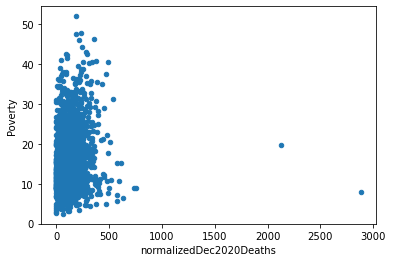

In [559]:
# f
print(df['normalizedDec2020Deaths'].corr(df['Poverty']))
df.plot.scatter(x='normalizedDec2020Deaths', y='Poverty')

-0.0035631552176380752


<AxesSubplot:xlabel='normalizedDec2020Cases', ylabel='PerCapitaIncome'>

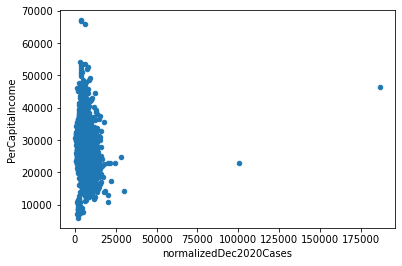

In [560]:
# g.COVID cases during December 2020 vs. Per Capita Income level
print(df['normalizedDec2020Cases'].corr(df['PerCapitaIncome']))
df.plot.scatter(x='normalizedDec2020Cases', y='PerCapitaIncome')

-0.11014163400704882


<AxesSubplot:xlabel='normalizedDec2020Deaths', ylabel='PerCapitaIncome'>

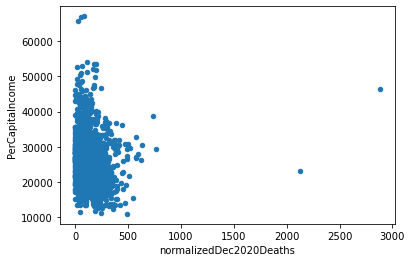

In [561]:
# h.COVID deaths during December 2020 vs. Per Capita Income level
print(df['normalizedDec2020Deaths'].corr(df['PerCapitaIncome']))
df.plot.scatter(x='normalizedDec2020Deaths', y='PerCapitaIncome')